In [1]:
import pyrpl

HOSTNAME = '192.168.1.17'
p = pyrpl.Pyrpl(config='',  # do not use a config file
          #config='tutorial',  # this would continuously save the current redpitaya state to a file "tutorial.yml" 
          hostname=HOSTNAME)

#check the value of input1
print(p.rp.scope.voltage_in1)

c:\Users\kichi\Documents\Kichi@git\pyrpl\pyrpl-env\lib\site-packages\paramiko\transport.py:32: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography.hazmat.backends import default_backend
INFO:pyrpl.redpitaya:Successfully connected to Redpitaya with hostname 192.168.1.17.


-0.012939453125


In [4]:
#blink some leds for 5 seconds
from time import sleep
for i in range(1025):
    p.rp.hk.led=i
    sleep(0.005)

In [5]:
r = p.rp #redpitaya object
r.hk #"housekeeping" = LEDs and digital inputs/outputs
r.ams #"analog mixed signals" = auxiliary ADCs and DACs.

r.scope #oscilloscope interface

r.asg0 #"arbitrary signal generator" channel 1
r.asg1 #"arbitrary signal generator" channel 2

r.pid0 #first of four PID modules
r.pid1
r.pid2

r.iq0 #first of three I+Q quadrature demodulation/modulation modules
r.iq1
r.iq2

r.iir #"infinite impules response" filter module that can realize complex transfer functions

In [10]:
asg = r.asg0 # make a shortcut
print("Trigger sources:", asg.trigger_sources)
print("Output options: ", asg.output_directs)

Trigger sources: odict_keys(['off', 'immediately', 'ext_positive_edge', 'ext_negative_edge', 'ext_raw', 'high'])
Output options:  odict_keys(['off', 'out1', 'out2', 'both'])


In [7]:
asg.output_direct = 'out2'
asg.setup(waveform='halframp', frequency=20e4, amplitude=0.8, offset=0, trigger_source='immediately')

In [8]:
s = p.rp.scope # shortcut
print("Available decimation factors:", s.decimations)
print("Trigger sources:", s.trigger_sources)
print("Available inputs: ", s.inputs)

Available decimation factors: odict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536])
Trigger sources: odict_keys(['off', 'immediately', 'ch1_positive_edge', 'ch1_negative_edge', 'ch2_positive_edge', 'ch2_negative_edge', 'ext_positive_edge', 'ext_negative_edge', 'asg0', 'asg1', 'dsp'])
Available inputs:  ['in1', 'in2', 'out1', 'out2', 'iq0', 'iq1', 'iq2', 'iq2_2', 'pid0', 'pid1', 'pid2', 'asg0', 'asg1', 'trig', 'iir', 'off', 'networkanalyzer', 'lockbox.inputs.input_from_output', 'lockbox.outputs.output1']


In [11]:
s.inputs

['in1',
 'in2',
 'out1',
 'out2',
 'iq0',
 'iq1',
 'iq2',
 'iq2_2',
 'pid0',
 'pid1',
 'pid2',
 'asg0',
 'asg1',
 'trig',
 'iir',
 'off',
 'networkanalyzer',
 'lockbox.inputs.input_from_output',
 'lockbox.outputs.output1']


Before turning on asg:
Curve ready: True

After turning on asg:
Curve ready: True
Trigger event age [ms]: 118.79017600000002


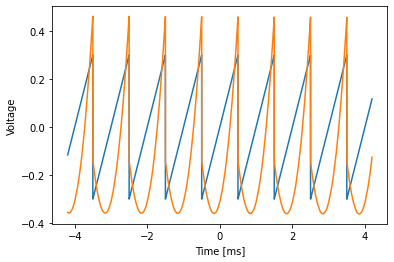

In [16]:
from pyrpl.async_utils import sleep
from pyrpl import RedPitaya
from matplotlib import pyplot as plt

#reload everything
r = p.rp #redpitaya object
asg = r.asg1
s = r.scope

# turn off asg so the scope has a chance to measure its "off-state" as well 
asg.output_direct = "off"

# setup scope
s.input1 = 'asg1'

# pass asg signal through pid0 with a simple integrator - just for fun (detailed explanations for pid will follow)
r.pid0.input = 'asg1' 
r.pid0.ival = 0 # reset the integrator to zero
r.pid0.i = 1000 # unity gain frequency of 1000 hz
r.pid0.p = 1.0 # proportional gain of 1.0
r.pid0.inputfilter = [0,0,0,0] # leave input filter disabled for now

# show pid output on channel2
s.input2 = 'pid0'

# trig at zero volt crossing
s.threshold_ch1 = 0 

# positive/negative slope is detected by waiting for input to 
# sweept through hysteresis around the trigger threshold in 
# the right direction 
s.hysteresis_ch1 = 0.01

# trigger on the input signal positive slope
s.trigger_source = 'ch1_positive_edge'

# take data symetrically around the trigger event
s.trigger_delay = 0

# set decimation factor to 64 -> full scope trace is 8ns * 2^14 * decimation = 8.3 ms long
s.decimation = 64

# only 1 trace average
s.trace_average = 1

# setup the scope for an acquisition
curve = s.single_async()
sleep(0.001)
print("\nBefore turning on asg:")
print("Curve ready:", s.curve_ready()) # trigger should still be armed

# turn on asg and leave enough time for the scope to record the data
asg.setup(frequency=1e3, amplitude=0.3, start_phase=90, waveform='halframp', trigger_source='immediately')
sleep(0.010)

# check that the trigger has been disarmed
print("\nAfter turning on asg:")
print("Curve ready:", s.curve_ready())
print("Trigger event age [ms]:",8e-9*((s.current_timestamp&0xFFFFFFFFFFFFFFFF) - s.trigger_timestamp)*1000)

# plot the data
%matplotlib inline
curve = curve.result()
plt.plot(s.times*1e3, curve[0], s.times*1e3, curve[1]);
plt.xlabel("Time [ms]");
plt.ylabel("Voltage");

In [18]:
# useful functions for scope diagnostics
print("Curve ready:", s.curve_ready())
print("Trigger source:",s.trigger_source)
print("Trigger threshold [V]:",s.threshold_ch1)
# print("Trigger threshold [V]:",s.threshold)
print("Averaging:",s.average)
print("Trigger delay [s]:",s.trigger_delay)
print("Trace duration [s]: ",s.duration)
# print("Trigger hysteresis [V]", s.hysteresis_ch1)
print("Trigger hysteresis [V]", s.hysteresis)
print("Current scope time [cycles]:",hex(s.current_timestamp))
print("Trigger time [cycles]:",hex(s.trigger_timestamp))
print("Current voltage on channel 1 [V]:", r.scope.voltage_in1)
print("First point in data buffer 1 [V]:", s.ch1_firstpoint)

Curve ready: True
Trigger source: ch1_positive_edge
Trigger threshold [V]: 0.0
Averaging: False
Trigger delay [s]: 0.0
Trace duration [s]:  0.008388608
Trigger hysteresis [V] 0.010009765625
Current scope time [cycles]: 0x933602b262
Trigger time [cycles]: 0x5007dcdbd5
Current voltage on channel 1 [V]: -0.2220458984375
First point in data buffer 1 [V]: -0.286865234375


In [20]:
print(r.pid0.help())

Please refer to the docstring of the function setup() or to the manual for further help! 


In [21]:
#make shortcut
pid = r.pid0

#turn off by setting gains to zero
pid.p,pid.i = 0,0
print("P/I gain when turned off:", pid.i,pid.p)

ERROR:pyrpl.redpitaya_client:Error occured in reading attempt 0. Reconnecting at addr 0x40300108 to _writes value [0] by client 1
ERROR:paramiko.transport:Socket exception: 远程主机强迫关闭了一个现有的连接。 (10054)


KeyboardInterrupt: 